In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qml.kernels import gaussian_kernel
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gpytorch
import random
import torch
import math
torch.set_default_dtype(torch.float64)

In [2]:
def largest_power_of_two(N):
    """
    Find the largest power of two less than or equal to a given integer.
    
    This function takes the training set size N as input and returns the largest power of two less than or equal to N.
    It also returns a list of all powers of two less than or equal to N.
    
    Parameters:
        N (int): A positive integer.
        
    Returns:
        A tuple containing:
            - An integer representing the largest power of two less than or equal to N.
            - A list of all powers of two less than or equal to N.
    """
    n = 0
    while 2**n < N:
        n += 1
    
    powers = []
    for i in range(1,n):
        if 2**i <= N:
            powers.append(2**i)
        else:
            break
    return n - 1,powers

In [3]:
np.random.seed(27)

# Define output functions
def f1(x):
    return np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.exp(x[:, 2]) + np.sin(x[:, 3]) + np.cos(x[:, 4])
def f2(x):
    return np.cos(x[:, 0]) + np.exp(x[:, 1]) + np.sin(x[:, 2]) + np.cos(x[:, 3]) + np.exp(x[:, 4])
def f3(x):
    return np.sin(x[:, 0]) + np.exp(x[:, 1]) + np.cos(x[:, 2]) + np.sin(x[:, 3]) + np.exp(x[:, 4])
# Generate 3000 samples of 5 dimensional input X with random numbers between 0 and 1
X = np.random.rand(3000, 5)

# Generate 3 dimensional output Y using output functions
Y = np.zeros((3000, 3))
Y[:, 0] = f1(X)
Y[:, 1] = f2(X)
Y[:, 2] = f3(X)
largest_two,train_sizes=largest_power_of_two(len(X))

In [4]:
shuffles_x_dummy = np.load('../Dummy Data/Dummy Shuffles/shuffles_x_rotated_dummy.npy')
shuffles_output_dummy=[np.load('../Dummy Data/Dummy Shuffles/shuffles_y1_rotated_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y2_rotated_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y3_rotated_dummy.npy')]
#concatenate the output shuffles
output_shuffles=[]

for i in range(len(shuffles_output_dummy[0])):
    temp_arr1=np.array(shuffles_output_dummy[0][i])
    temp_arr2=np.array(shuffles_output_dummy[1][i])
    temp_arr3=np.array(shuffles_output_dummy[2][i])
    arr=np.column_stack((temp_arr1,temp_arr2,temp_arr3))
    output_shuffles.append(arr)
    
output_shuffles=np.array(output_shuffles)

In [5]:
def check_duplicate(array):
    """
    Check if any two elements in an array are equal.
    Used in the check_shuffles() function to make sure all the shuffles are distinct.

    Parameters:
        array: A list or array of numpy ndarrays.

    Returns:
        True if any two elements in the array are equal, False otherwise.
    """
    seen = set()
    for element in array:
        temp_element = tuple(element.flatten())
        if temp_element in seen:
            return True
        seen.add(temp_element)
    return False
def check_shuffles():
    """
    Check the shuffles used for a given dataset to ensure they are distinct.

    Returns:
        True if no duplicate shuffles are found, False otherwise.
    """
    for i in range(3):
        if check_duplicate(shuffles_output_dummy[i])== True:
            return False
    if check_duplicate(shuffles_x_dummy)==True:
        return False
    return True

if check_shuffles()==False:
    print("Two or more shuffles are identical. Please run setup again to reshuffle")

In [6]:

def rotation_matrix(axis, theta):
    """
    Creates a rotation matrix given the axes about 
    which to rotate and the angle
    using Euler-Rodrigues formula
    
    Parameters:
        axis(numpy array): array indicated about which axes to rotate
        theta(int): rotation angle, in radians
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

rotated_Y = np.zeros((3000, 3))

#45 degree rotation about the all axes
for i in range(len(Y)):
    rotated_Y[i] = np.dot(rotation_matrix([1, 1, 1], np.deg2rad(45)), Y[i])


In [7]:
# define the Multitask Gaussian process regression model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [8]:
def initialise(X_train_param,y_train_param):
    """
    Initializes the Multitask Gaussian Process model with the given training data and kernel hyperparameters.

    Args:
    X_train_param (numpy.ndarray): Input data for training.
    y_train_param (numpy.ndarray): Output data for training.
    """
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9),
                                                        num_tasks=3)
    train_x = torch.as_tensor(X_train_param, dtype = torch.float64)
    train_y = torch.as_tensor(y_train_param, dtype = torch.float64)
    model = MultitaskGPModel(train_x, train_y, likelihood)
        
    hypers={
        'likelihood.noise':torch.tensor(10**-9),
        'covar_module.data_covar_module.lengthscale':torch.tensor(100),
    }
    model.initialize(**hypers)

In [9]:
def GPR(train_x,train_y,test_x,test_y):
    """
    Performs Multitask Gaussian Process Regression (MTGPR) and calculates the mean absolute error between 
    predicted and actual values.

    Parameters:
        train_x (numpy array): Input data for training
        train_y (numpy array): Output data for training
        test_x (numpy array): Array of input testing data.
        test_y (numpy array): Array of output testing data.

    Returns:
        The mean absolute error between predicted and actual values.
    """
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x = torch.as_tensor(test_x, dtype = torch.float64)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9),
                                                     num_tasks=3)
    model = MultitaskGPModel(train_x, train_y, likelihood)
    
    hypers={
    'likelihood.noise':torch.tensor(10**-9),
    'covar_module.data_covar_module.lengthscale':torch.tensor(100),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))

    mean = observed_pred.mean.detach().numpy()
    return np.mean(np.abs(mean - test_y))

In [10]:

def learning_curve(x_test,y_test):
    """
    Calculates the mean absolute errors of different training sizes
    for a given dataset.

    Parameters:
        x_test (numpy array): Input data for testing.
        y_test (numpy array): Output data for testing.
    Returns:
        mae_list (numpy array): An array of mean absolute errors for each training size in the learning curve.
    """
    mae_list=np.zeros(largest_two,dtype=float)
    for j in range(10):
        X_train1,y_train1=shuffles_x_dummy[j],output_shuffles[j]
        maes=[]
        for i in (2**p for p in range(1,largest_two+1)):
                temp_mae=GPR(X_train1[0:i],y_train1[0:i],x_test,y_test)
                maes.append(temp_mae)
        mae_list[:]=np.copy(maes)
    mae_list=mae_list/10
    return mae_list

In [11]:
def lc_plots():
    '''
    Plots the learning curves for the transition dipole moment components of a given dataset.

    '''
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, rotated_Y, shuffle=False, train_size=0.8)

    result=learning_curve(X_test1,y_test1)    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.figure(dpi=1200) 
    ax.loglog(train_sizes, result, marker='.', markersize=10, linewidth=2, color='tab:cyan')

    ax.set_xlabel('Number of Training Samples', fontsize=14)
    ax.set_ylabel('Mean Absolute Error', fontsize=14)
    ax.set_title('MTGPR Learning Curve for the output components', fontsize=16)
    plt.show()

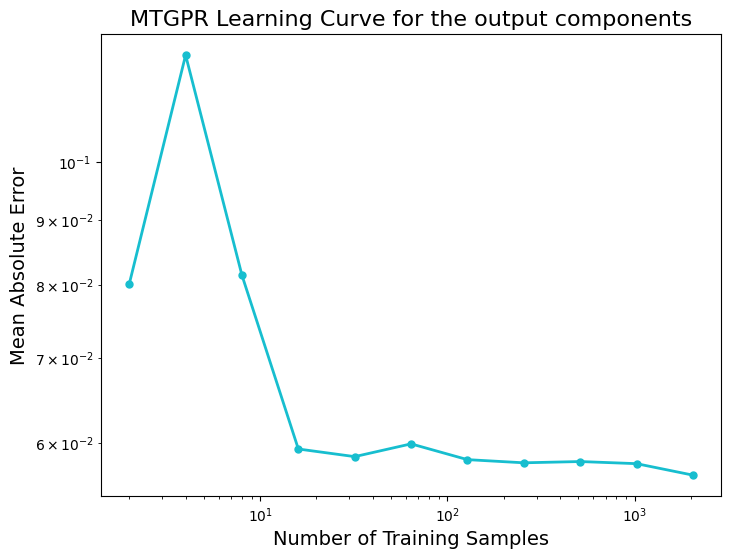

<Figure size 7680x5760 with 0 Axes>

In [12]:
lc_plots()

In [13]:
def GPR_predicted(train_x,train_y,test_x,test_y):
    """
    Multitask Gaussian Process Regression.

    Parameters:
        train_x (numpy array): Input data for training
        train_y (numpy array): Output data for training, corresponding to an array of scalar values.
        test_x (numpy array): Input data for testing
        test_y (numpy array): Output data for testing, corresponding to an array of scalar values.
            
    Returns:
        mean(numpy array): The values predicted for the given testing data.
    """
    train_x = torch.as_tensor(train_x, dtype = torch.float64)
    train_y = torch.as_tensor(train_y, dtype = torch.float64)
    test_x = torch.as_tensor(test_x, dtype = torch.float64)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(10**-9),
                                                     num_tasks=3)
    model = MultitaskGPModel(train_x, train_y, likelihood)
    
    hypers={
    'likelihood.noise':torch.tensor(10**-9),
    'covar_module.data_covar_module.lengthscale':torch.tensor(100),
    }
    model.initialize(**hypers)
    model.eval()
    likelihood.eval()
    # Use the model to make predictions on the test_x values
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Feed the test_x values through the model and likelihood to get predicted distribution over observed values
        observed_pred = likelihood(model(test_x))

    mean = observed_pred.mean.detach().numpy()
    return mean

def scatter_plot():
    """
    Plots a scatter plot of predicted vs actual values for the transition dipole moment components using Multitask Gaussian Regression
    """
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, rotated_Y, shuffle=False, train_size=0.8)

    y_predicted_values=GPR_predicted(X_train1,y_train1,X_test1,y_test1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Comparison of predicted and actual values', fontsize=16)
    for i, ax in enumerate(axs):
        ax.plot([y_test1[:,i].min(), y_test1[:,i].max()], [y_test1[:,i].min(), y_test1[:,i].max()], 'k--', lw=2)
        ax.scatter(y_predicted_values[:,i],y_test1[:,i])
        ax.set_xlabel('Predicted values', fontsize=14)
        ax.set_ylabel('Actual values', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)
    plt.subplots_adjust(wspace=0.3)
    plt.show()


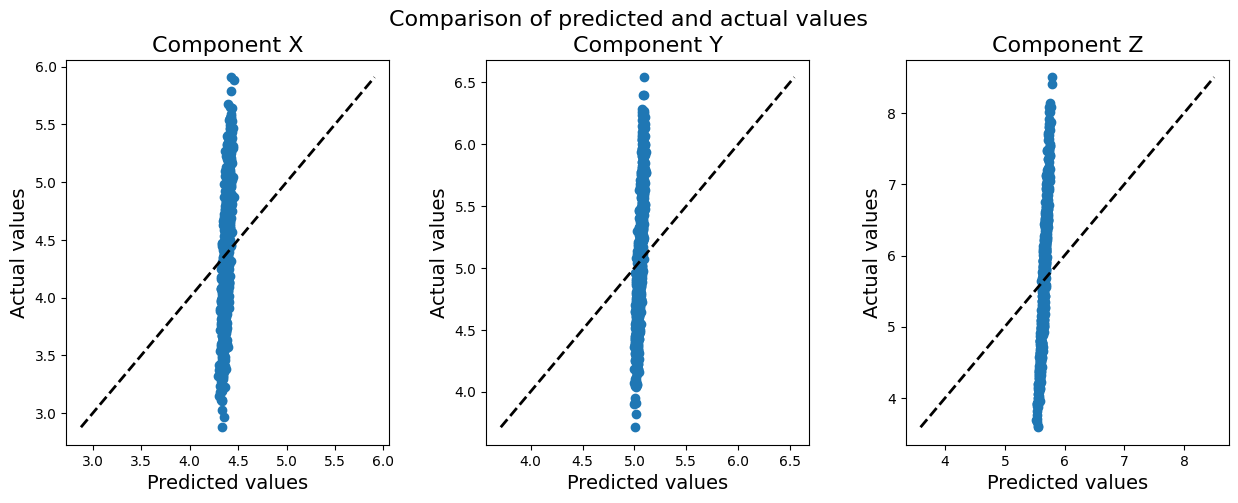

In [14]:
scatter_plot()